## Second Session

---------------


## Message passing with [Deep Graph Library (DGL)](https://docs.dgl.ai/index.html) for the graduate course "[Graph Machine learning](https://github.com/zahta/graph_ml)"
##### by [Zahra Taheri](https://github.com/zahta), 30 May 2023

---------------

### This Tutorial Is Prepared Based on the Following References

- [Deep Learning on Graphs (a Tutorial)](https://cloud4scieng.org/2020/08/28/deep-learning-on-graphs-a-tutorial/)
- [A Blitz Introduction to DGL](https://docs.dgl.ai/en/latest/tutorials/blitz/index.html)
  
- [User Guide](https://docs.dgl.ai/en/latest/guide/index.html#)


In [1]:
%matplotlib inline
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import dgl.function as fn
import torch.nn.functional as F

### DGL Graph Construction

In [2]:
src_ids = torch.tensor([1, 2, 3])
dst_ids = torch.tensor([2, 3, 0])
g = dgl.graph((src_ids, dst_ids), num_nodes=5)
print(g)

Graph(num_nodes=5, num_edges=3,
      ndata_schemes={}
      edata_schemes={})


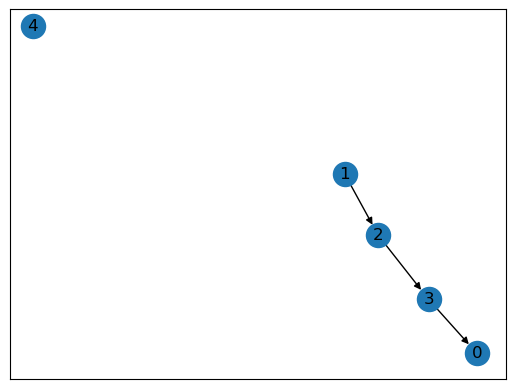

In [3]:
nx.draw_networkx(g.to_networkx(), with_labels = True)

In [4]:
g.ndata['x'] = torch.ones(5, 3)
g.ndata

{'x': tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])}

In [5]:
g.edata['w'] = torch.ones(3, 2)
g.edata

{'w': tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])}

### [Computing with DGLGraph](https://docs.dgl.ai/api/python/dgl.DGLGraph.html#computing-with-dglgraph)

Some examples:

**DGLGraph.apply_nodes(func, v='__ALL__', ntype=None)**

Update the features of the specified nodes by the provided function.

Parameters:
func (callable) – The function to update node features. It must be a User-defined Functions.

v (node IDs) – The node IDs. The allowed formats are:

- int: A single node.

- Int Tensor: Each element is a node ID. The tensor must have the same device type and ID data type as the graph’s.

- iterable[int]: Each element is a node ID.

- If not given (default), use all the nodes in the graph.

ntype (str, optional) – The node type name. It can be omitted if there is only one type of nodes in the graph.


**DGLGraph.apply_edges(func, edges='__ALL__', etype=None)**

Update the features of the specified edges by the provided function.

Parameters:
func (dgl.function.BuiltinFunction or callable) – The function to generate new edge features. It must be either a DGL Built-in Function or a User-defined Functions.

edges (edges) – The edges to update features on. The allowed input formats are:

- int: A single edge ID.

- Int Tensor: Each element is an edge ID. The tensor must have the same device type and ID data type as the graph’s.

- iterable[int]: Each element is an edge ID.

- (Tensor, Tensor): The node-tensors format where the i-th elements of the two tensors specify an edge.

- (iterable[int], iterable[int]): Similar to the node-tensors format but stores edge endpoints in python iterables.

Default value specifies all the edges in the graph.

etype (str or (str, str, str), optional) – The type name of the edges. The allowed type name formats are: (str, str, str) for source node type, edge type and destination node type. or one str edge type name if the name can uniquely identify a triplet format in the graph. It can be omitted if the graph has only one type of edges.

**Notes**

DGL recommends using DGL’s bulit-in function for the func argument, because DGL will invoke efficient kernels that avoids copying node features to edge features in this case.

In [6]:
g.apply_nodes(lambda nodes: {'y' : nodes.data['x'] * 2})
g.ndata['y']

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

In [7]:
def func_v(nodes):
    return {'z': nodes.data['x'] * 3}
g.apply_nodes(func_v)
g.ndata['z']

tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]])

In [8]:
g.apply_edges(lambda edges: {'p' : edges.data['w'] * 4})
g.edata['p']

tensor([[4., 4.],
        [4., 4.],
        [4., 4.]])

In [9]:
def func_e(edges):
    return {'s': edges.src['x'] *5}
g.apply_edges(func_e)
g.edata['s']

tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]])

In [10]:
def func_e(edges):
    return {'d': edges.dst['x'] *5}
g.apply_edges(func_e)
g.edata['d']

tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]])

In [11]:
g.edata

{'w': tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]), 'p': tensor([[4., 4.],
        [4., 4.],
        [4., 4.]]), 's': tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]]), 'd': tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]])}

Message passing and GNNs
------------------------

DGL follows the *message passing paradigm* inspired by the Message Passing Neural Network proposed by [Gilmer et.al.](https://arxiv.org/abs/1704.01212) Essentially, they found many GNN models can fit into the following framework:

\begin{align}m_{u\to v}^{(l)} = M^{(l)}\left(h_v^{(l-1)}, h_u^{(l-1)}, e_{u\to v}^{(l-1)}\right)\end{align}

\begin{align}m_{v}^{(l)} = \sum_{u\in\mathcal{N}(v)}m_{u\to v}^{(l)}\end{align}

\begin{align}h_v^{(l)} = U^{(l)}\left(h_v^{(l-1)}, m_v^{(l)}\right)\end{align}

where DGL calls $M^{(l)}$ the **message function**, $\sum$ the
**reduce function** and $U^{(l)}$ the **update function**. Note that
$\sum$ here can represent any function and is not necessarily a
summation.




**[Messages Functions:](https://docs.dgl.ai/api/python/dgl.function.html#dgl-function)** Messages are associated with edges. Each message is usually taken from the source node of the edge e and delivered to the "mailbox" of the edge's destination. Although, the value can be determined based on features of edges or nodes incident to the edge, e. Note that the messages are delivered to a mailbox of the destination node. Indeed, we should choose a unique name for the mailbox of all nodes.  

**[Reduce Functions:](https://docs.dgl.ai/api/python/dgl.function.html#reduce-functions)** This function empties the mailboxes of nodes. Each mailbox may contain several messages delivered by its source nodes. 

In [12]:
# DGLGraph.update_all(message_func, reduce_func, apply_node_func=None, etype=None)
g.update_all(fn.copy_u('z', 'm'), fn.sum('m', 'total') )
g.ndata['total']

tensor([[3., 3., 3.],
        [0., 0., 0.],
        [3., 3., 3.],
        [3., 3., 3.],
        [0., 0., 0.]])

The central piece in this code is the **g.update_all** function, which gathers and sums the neighbor features. There are three concepts here:

* Message function ``fn.copy_u('h', 'm')`` that
  copies the node feature under name ``'h'`` as *messages* with name
  ``'m'`` sent to neighbors.

* Reduce function ``fn.sum('m', 'total')`` that sums
  all the received messages under name ``'m'`` and saves the result as a
  new node feature ``'total'``.

* ``update_all`` tells DGL to trigger the
  message and reduce functions for all the nodes and edges.




In [13]:
g.update_all(fn.copy_u('z', 'mailbox'), fn.sum('mailbox', 'newtotal') )
g.ndata['newtotal']

tensor([[3., 3., 3.],
        [0., 0., 0.],
        [3., 3., 3.],
        [3., 3., 3.],
        [0., 0., 0.]])

### User Defined Message and Reduced Functions

In [14]:
def message_func(edges):
    return {'mailbox' : 3*edges.src['x'] }

def reduce_func(nodes):
    total = torch.sum(nodes.mailbox['mailbox'], dim=1)
    return {'total2' : total}

In [15]:
# DGLGraph.update_all(message_func, reduce_func, apply_node_func=None, etype=None)
g.update_all(message_func, reduce_func)

In [16]:
g.ndata['total2']

tensor([[3., 3., 3.],
        [0., 0., 0.],
        [3., 3., 3.],
        [3., 3., 3.],
        [0., 0., 0.]])

## Readout

In [Batching nd Read Out Ops](https://docs.dgl.ai/api/python/dgl.html#batching-and-reading-out-ops) you can find some well-known DGL read out functions.

**dgl.readout_nodes(graph, feat, weight=None, *, op='sum', ntype=None)**     
**dgl.readout_edges(graph, feat, weight=None, *, op='sum', etype=None)**   


In [17]:
dgl.readout_nodes(g,'total')

tensor([[9., 9., 9.]])

# Run a message-passing function with DGL

In [18]:
list_src = []
list_dst = []
num_nodes = 7
for i in range(num_nodes):
    list_src.append(i)
    list_dst.append((i+1)%num_nodes) 
print([list_src,list_dst])

# create DGL graph
graph_dgl = dgl.graph((list_src, list_dst))
graph_dgl = dgl.to_bidirected(graph_dgl) # symmetrize/undirected graph
print(graph_dgl)


[[0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 0]]
Graph(num_nodes=7, num_edges=14,
      ndata_schemes={}
      edata_schemes={})


In [19]:
graph_dgl.ndata['feat'] = graph_dgl.in_degrees().view(-1, 1).float() # node in-degree
graph_dgl.edata['feat'] = torch.rand(graph_dgl.num_edges(), 100) # random features
print(graph_dgl)


Graph(num_nodes=7, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)})


In [20]:
# Step 1 of message-passing with DGL
#   Node feature and edge features are passed along edges (src/j => dst/i) 
def message_func(edges):
    hi = edges.dst['feat'] # hi with i/dst, size=(E,d=1)
    print('hi',hi.size())
    hj = edges.src['feat'] # hj with j/src, size=(E,d=1)
    eji = edges.data['feat']# eji from src/j to dst/i, size=(E,d=100)
    print('eji',eji.size())
    edges.data['feat'] = 2 * edges.data['feat'] # update edge feature value
    return {'hj' : hj, 'eji' : eji} # send message={hj, eji} to node dst/i

# Step 2 of message-passing with DGL:
#   Reduce function collects all messages={hj, eji} sent to node dst/i with Step 1
def reduce_func(nodes):
    hi = nodes.data['feat'] # size=(N,d=1)
    print('hi',hi.size())
    hj = nodes.mailbox['hj'] # size=(N,|Nj|,d=1), |Nj|=num_neighbors
    print('hj',hj.size())
    eji = nodes.mailbox['eji'] # size=(N,|Nj|,d=100), |Nj|=num_neighbors
    print('eji',eji.size())
    h = hi + torch.sum( eji * hj, dim=1 ) # hi = hi + sum_j eta_ji * hj, size=(N,d=100) 
    print('h',h.size())
    return {'h' : h} # return update node feature hi

graph_dgl.update_all(message_func,reduce_func) # update the node and edge features with DGL


hi torch.Size([14, 1])
eji torch.Size([14, 100])
hi torch.Size([7, 1])
hj torch.Size([7, 2, 1])
eji torch.Size([7, 2, 100])
h torch.Size([7, 100])


Even more customization by user-defined function
------------------------------------------------

DGL allows user-defined message and reduce function for the maximal
expressiveness. Here is a user-defined message function that is
equivalent to ``fn.u_mul_e('h', 'w', 'm')``.




In [21]:
def u_mul_e_udf(edges):
    return {"m": edges.src["h"] * edges.data["w"]}

``edges`` has three members: ``src``, ``data`` and ``dst``, representing
the source node feature, edge feature, and destination node feature for
all edges.




You can also write your own reduce function. For example, the following
is equivalent to the builtin ``fn.mean('m', 'h_N')`` function that averages
the incoming messages:




In [22]:
def mean_udf(nodes):
    return {"h_N": nodes.mailbox["m"].mean(1)}

In short, DGL will group the nodes by their in-degrees, and for each
group DGL stacks the incoming messages along the second dimension. You
can then perform a reduction along the second dimension to aggregate
messages.

For more details on customizing message and reduce function with
user-defined function, please refer to the `API
reference <apiudf>`.




Best practice of writing custom GNN modules
-------------------------------------------

DGL recommends the following practice ranked by preference:

-  Use ``dgl.nn`` modules.
-  Use ``dgl.nn.functional`` functions which contain lower-level complex
   operations such as computing a softmax for each node over incoming
   edges.
-  Use ``update_all`` with builtin message and reduce functions.
-  Use user-defined message or reduce functions.




### Write your own GNN module

For example, the GraphSAGE convolution [Hamilton et al.,](https://cs.stanford.edu/people/jure/pubs/graphsage-nips17.pdf)
takes the following mathematical form:

\begin{align}h_{\mathcal{N}(v)}^k\leftarrow \text{Average}\{h_u^{k-1},\forall u\in\mathcal{N}(v)\}\end{align}

\begin{align}h_v^k\leftarrow \text{ReLU}\left(W^k\cdot \text{CONCAT}(h_v^{k-1}, h_{\mathcal{N}(v)}^k) \right)\end{align}

You can see that message passing is directional: the message sent from
one node $u$ to other node $v$ is not necessarily the same
as the other message sent from node $v$ to node $u$ in the
opposite direction.

Although DGL has builtin support of GraphSAGE via
:class:`dgl.nn.SAGEConv <dgl.nn.pytorch.SAGEConv>`,
here is how you can implement GraphSAGE convolution in DGL by your own.




In [23]:
class SAGEConv(nn.Module):
    """Graph convolution module used by the GraphSAGE model.

    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    """

    def __init__(self, in_feat, out_feat):
        super(SAGEConv, self).__init__()
        # A linear submodule for projecting the input and neighbor feature to the output.
        self.linear = nn.Linear(in_feat * 2, out_feat)

    def forward(self, g, h):
        """Forward computation

        Parameters
        ----------
        g : Graph
            The input graph.
        h : Tensor
            The input node feature.
        """
        with g.local_scope():
            g.ndata["h"] = h
            # update_all is a message passing API.
            g.update_all(
                message_func=fn.copy_u("h", "m"),
                reduce_func=fn.mean("m", "h_N"),
            )
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            return self.linear(h_total)

Afterwards, you can stack your own GraphSAGE convolution layers to form
a multi-layer GraphSAGE network.




In [24]:
class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

### Training loop

The following code for data loading and training loop is directly copied
from the introduction tutorial.




In [25]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]


def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    all_logits = []
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    for e in range(200):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that we should only compute the losses of the nodes in the training set,
        # i.e. with train_mask 1.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_logits.append(logits.detach())

        if e % 5 == 0:
            print(
                "In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(
                    e, loss, val_acc, best_val_acc, test_acc, best_test_acc
                )
            )


model = Model(g.ndata["feat"].shape[1], 16, dataset.num_classes)
train(g, model)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
In epoch 0, loss: 1.949, val acc: 0.058 (best 0.058), test acc: 0.064 (best 0.064)
In epoch 5, loss: 1.886, val acc: 0.182 (best 0.182), test acc: 0.205 (best 0.205)
In epoch 10, loss: 1.750, val acc: 0.484 (best 0.484), test acc: 0.450 (best 0.450)
In epoch 15, loss: 1.538, val acc: 0.584 (best 0.584), test acc: 0.581 (best 0.581)
In epoch 20, loss: 1.257, val acc: 0.634 (best 0.634), test acc: 0.642 (best 0.642)
In epoch 25, loss: 0.938, val acc: 0.678 (best 0.678), test acc: 0.670 (best 0.670)
In epoch 30, loss: 0.634, val acc: 0.720 (best 0.720), test acc: 0.712 (best 0.712)
In epoch 35, loss: 0.392, val acc: 0.744 (best 0.744), test acc: 0.740 (best 0.732)
In epoch 40, loss: 0.229, val acc: 0.738 (best 0.744), test acc: 0.755 (best 0.732)
In epoch 45, loss: 0.132, val acc: 0.740 (best 0.744), test acc: